In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from CACTUS import *
from multiprocessing import Pool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns

In [3]:
data = Cn2.read_csv('/scratchm/eklotz/Cn2_Tenerife_2020_fromSoundings.csv')
data.set_ground_level()
data.rm_zeros()
data.filtre(50)
data.rm_incomplete(20000)

100%|██████████| 714/714 [00:00<00:00, 761.54it/s] 
17 dates invalides sur 714
['2020-01-07 11:00:00' '2020-02-09 23:00:00' '2020-02-22 23:00:00'
 '2020-02-23 00:00:00' '2020-02-23 11:00:00' '2020-02-23 12:00:00'
 '2020-03-21 11:00:00' '2020-03-24 23:00:00' '2020-04-08 11:00:00'
 '2020-06-16 23:00:00' '2020-07-05 23:00:00' '2020-11-25 23:00:00'
 '2020-12-02 11:00:00' '2020-12-02 23:00:00' '2020-12-03 23:00:00'
 '2020-12-04 11:00:00' '2020-12-04 23:00:00']


In [4]:
true_moments = data.moments(zenithAngle= 60/180 * np.pi)
true_moments

,r0,seeing,theta0,tau0
date,,,,
2020-01-01 11:00:00,0.080466,0.000019,2.663034,0.001442
2020-01-01 23:00:00,0.072855,0.000021,1.987339,0.001065
2020-01-02 11:00:00,0.080336,0.000019,2.264267,0.001381
2020-01-03 11:00:00,0.084169,0.000018,3.388930,0.002052
2020-01-03 23:00:00,0.066210,0.000023,2.057467,0.001067
...,...,...,...,...
2020-12-29 23:00:00,0.062075,0.000024,1.914434,0.000837
2020-12-30 11:00:00,0.085307,0.000018,2.032592,0.000908
2020-12-30 23:00:00,0.068394,0.000022,1.864186,0.000593


In [5]:
decimated = pd.read_csv('/scratchm/eklotz/Gauss-Legendre-quadrature/every_possible_decimation.csv')

In [6]:
decimated

,Unnamed: 0,date,alt,Cn2,wspeed,nbsegements,nbpoints_per_segment
0,0,2020-01-01 11:00:00,16062.141888,1.215691e-16,17.062774,1,1
1,1,2020-01-01 23:00:00,15911.515867,1.052616e-16,26.540141,1,1
2,2,2020-01-02 11:00:00,10515.828608,1.746067e-16,10.005434,1,1
3,3,2020-01-03 11:00:00,14815.592002,1.155160e-16,19.801229,1,1
4,4,2020-01-03 23:00:00,14219.986736,1.509093e-16,27.895443,1,1
...,...,...,...,...,...,...,...
2107840,69595,2020-12-31 23:00:00,32011.124770,9.397735e-20,26.247474,10,10
2107841,69596,2020-12-31 23:00:00,32485.934091,-2.513376e-20,27.719261,10,10
2107842,69597,2020-12-31 23:00:00,32905.383912,2.258406e-19,30.644478,10,10
2107843,69598,2020-12-31 23:00:00,33222.584656,5.009496e-19,34.748477,10,10


In [7]:
def foo(x): 
    x = x.sort_values('alt')
    return calc_moments(x.Cn2.values, x.alt.values, x.wspeed.values, zenithAngle= 60/180 * np.pi)

In [8]:
moments = decimated.groupby(['nbsegements', 'nbpoints_per_segment', 'date']).progress_apply(foo)

100%|██████████| 69693/69693 [00:51<00:00, 1362.88it/s]


In [9]:
moments = moments.progress_apply(pd.Series)

100%|██████████| 69693/69693 [00:21<00:00, 3297.19it/s]


In [10]:
moments.reset_index(inplace=True)

In [11]:
def erreur(x):
    x = x.set_index('date')
    erreur_r0 = (np.abs(x.r0-true_moments.r0)/true_moments.r0)
    erreur_theta0 = (np.abs(x.theta0-true_moments.theta0)/true_moments.theta0)
    erreur_tau0 = (np.abs(x.tau0-true_moments.tau0)/true_moments.tau0)
    return pd.concat((erreur_r0, erreur_theta0, erreur_tau0), axis = 1)

In [12]:
erreur_moments = moments.groupby(['nbsegements', 'nbpoints_per_segment']).apply(erreur)

In [13]:
erreur_moments.replace([np.inf, -np.inf], np.nan, inplace=True)
erreur_moments

r0    theta0  \
nbsegements nbpoints_per_segment date                                      
1           1                    2020-01-01 11:00:00       NaN       NaN   
                                 2020-01-01 23:00:00       NaN       NaN   
                                 2020-01-02 11:00:00       NaN       NaN   
                                 2020-01-03 11:00:00       NaN       NaN   
                                 2020-01-03 23:00:00       NaN       NaN   
...                                                        ...       ...   
10          10                   2020-12-29 23:00:00  0.066589  0.212775   
                                 2020-12-30 11:00:00  0.048428  0.017414   
                                 2020-12-30 23:00:00  0.054832  0.011622   
                                 2020-12-31 11:00:00  0.066886  0.013624   
                                 2020-12-31 23:00:00  0.000464  0.017113   

                                                          tau0  
nbsegements nbpoints_per_segment date                           
1           1                    2020-01-01 11:00:00       NaN  
                                 2020-01-01 23:00:00       NaN  
                                 2020-01-02 11:00:00       NaN  
                                 2020-01-03 11:00:00       NaN  
                                 2020-01-03 23:00:00       NaN  
...                                                        ...  
10          10                   2020-12-29 23:00:00  0.170874  
                                 2020-12-30 11:00:00  0.000676  
                                 2020-12-30 23:00:00  0.011075  
                                 2020-12-31 11:00:00  0.029103  
                                 2020-12-31 23:00:00  0.015948  

[69700 rows x 3 columns]

In [14]:
erreur_moments_moy = erreur_moments.groupby(['nbsegements', 'nbpoints_per_segment']).mean()*100

<AxesSubplot:xlabel='nbpoints_per_segment', ylabel='nbsegements'>

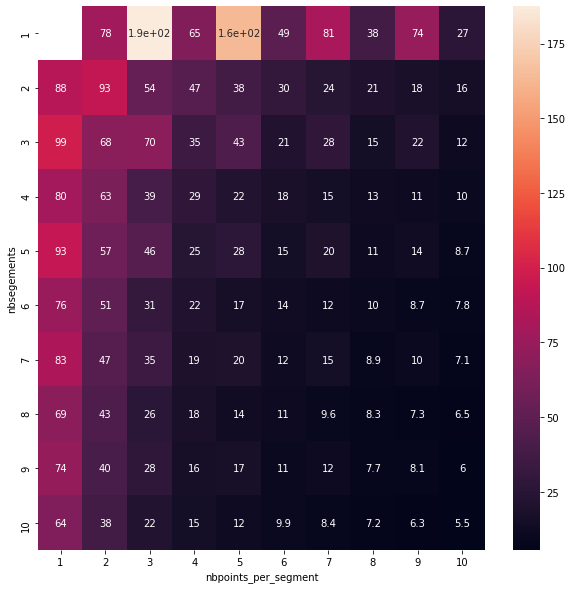

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(erreur_moments_moy.reset_index().pivot('nbsegements','nbpoints_per_segment', 'r0'), annot=True)

<AxesSubplot:xlabel='nbpoints_per_segment', ylabel='nbsegements'>

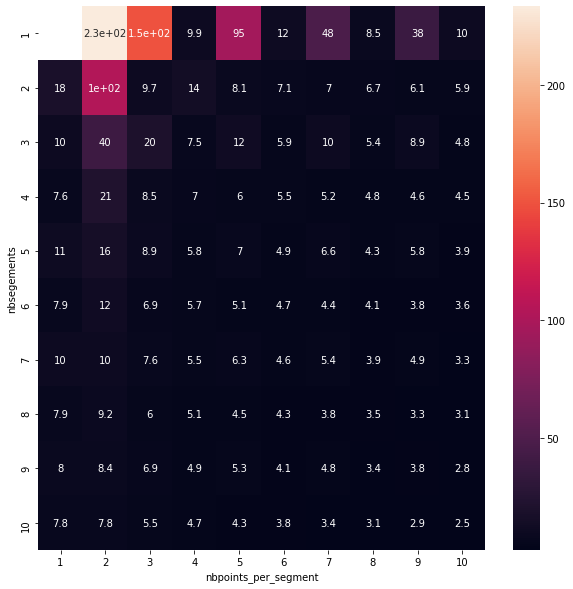

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(erreur_moments_moy.reset_index().pivot('nbsegements','nbpoints_per_segment', 'theta0'), annot=True)

<AxesSubplot:xlabel='nbpoints_per_segment', ylabel='nbsegements'>

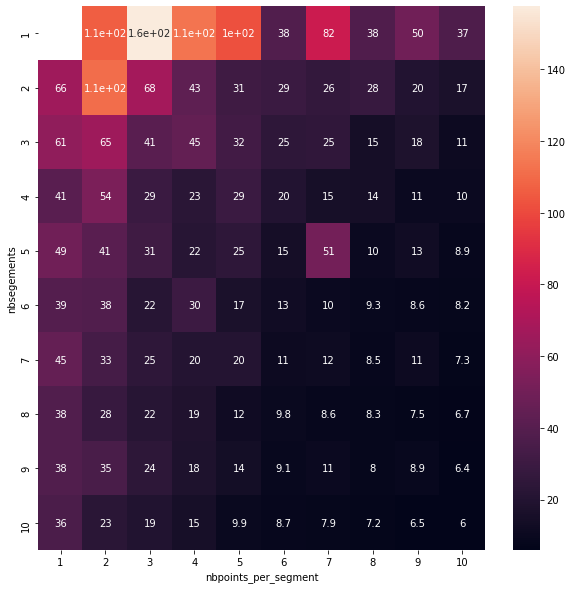

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(erreur_moments_moy.reset_index().pivot('nbsegements','nbpoints_per_segment', 'tau0'), annot=True)